In [2]:
import os
import re
import cv2
from cv2 import VideoCapture
import numpy as np
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from typing import List, Any, Union, Tuple, Callable
import os
import math
import random
from LaneFollowing import (
    find_lanes,
    average_slope_intercept,
    compute_steering_angle_lanelineslope,
    plotHistogram,
    slide_window_search,
    compute_steering_angle_lanelinecoord,
)
from houghapproach import display_heading_line
from functools import reduce


## Load images


In [3]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        # save frame as JPEG file
        cv2.imwrite(save_path + f"{count}.jpg", image)
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()


In [4]:
# convert bfmc_2020 videos to frames
vid_paths = [
    # "./data/Records/bfmc2020_online_1.avi",
    # "./data/Records/bfmc2020_online_2.avi",
    # "./data/Records/bfmc2020_online_3.avi",
     "./data/Records/home.mp4",
]

paths = []
path = f"./data/bfmc2020/frames_3/"  # edit this
paths.append(path)


In [5]:
for i, v_path in enumerate(vid_paths):
    path = f"./data/bfmc2020/frames_3/"  # edit this
    paths.append(path)
    video2frames(v_path, path)


Saved 2012 frames to ./data/bfmc2020/frames_3/.


In [6]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = "./data/bfmc2020/frames_3/"
col_images = import_images(path)
len(col_images)


  0%|          | 0/2163 [00:00<?, ?it/s]

2163

## Lane Keeping


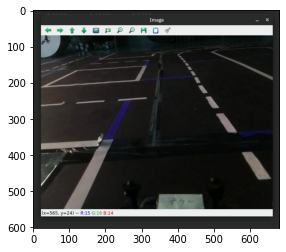

In [7]:
plt.imshow(col_images[100])

In [8]:
class LaneKeep:
    def __init__(
        self,
        use_perspective: bool = True,
        computation_method: str = "hough",
        blur_size: Tuple[int, int] = (7, 7),
        adpt_Th_blk_size: int = 21,
        adpt_Th_C: int = 4,
        canny_thres1: int = 40,
        canny_thres2: int = 60,
        luroi: float = 0.25,
        ruroi: float = 0.75,
        lbroi: float = 0,
        rbroi: float = 1,
        hroi: float = 0.55,
        debug:bool = True
    ):
        """Define LaneKeeping pipeline and parameters

        Args:
            preprocess_idx: which pipeine to use
                        1 -> [roi_func, preprocess]
                        2 -> [persepective_wrap, preprocess]
            blur_size: (Tuple[int, int]) Blur kernel size (preprocess)
            adpt_Th_blk_size: (int) Adaptive thresholding block size (preprocess)
            adpt_Th_C: (int) Adaptive thresholidng parameter C (preprocess)
            canny_thres1: (int) Canny Edge Detection threshold parameter (preprocess)
            canny_thres2: (int) Canny Edge Detection threshold parameter (preprocess)
            luroi: (float) left upper ROI region percent
            ruroi: (float) right upper ROI region percent
            lbroi: (float) left bottom ROI region percent
            rbroi: (float) right bottom ROI region percent
            hroi : (float) ROI region percent
            preprocess: (str) thres | canny
        """

        assert (
            computation_method == "hough" or computation_method == "sliding_window"
        ), f"Expected computation_method to be either 'hough' or 'sliding_window'"

        self.computation_method = computation_method
        self.blur_size = blur_size
        # Size of a pixel neighborhood that is used to calculate a threshold value for the pixel
        self.adpt_Th_blk_size = adpt_Th_blk_size
        # const substracted from mean (adaptive threshold)
        self.adpt_Th_C = adpt_Th_C
        # threshold for canny edge detection
        # https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de
        self.canny_thres1 = canny_thres1
        self.canny_thres2 = canny_thres2

        # perspective wrap
        self.luroi = luroi
        self.ruroi = ruroi
        self.lbroi = lbroi
        self.rbroi = rbroi
        self.hroi = hroi
        self.stencil = None
        self.debug = debug
        if use_perspective:
            pipeline_list = [self.persepective_wrap, self.preprocess]
        else:
            pipeline_list = [self.roi_func, self.preprocess]

        def compose(f, g):
            return lambda x: g(f(x))

        self.preprocess_pipeline = reduce(compose, pipeline_list, lambda x: x)

    def __call__(self, img: np.ndarray) -> np.ndarray:
        if self.computation_method == "sliding_window":
            return self.sliding_window_search(img) 
        else:
            return self.houghlines_angle(img)

    def roi_func(self, img: np.ndarray) -> np.ndarray:
        """Given image get Region of interest

        Args:
            img: (np.ndarray) input image

        Returns:
            np.ndarray: the roi image
        """
        # create stencil just the first time and then save for later use
        if self.stencil is None:
            roi = [
                (
                    int(self.luroi * ((img.shape[1] - 1))),
                    int(self.hroi * (img.shape[0] - 1)),
                ),
                (int(self.lbroi * ((img.shape[1] - 1))), int(img.shape[0] - 1)),
                (int(self.rbroi * ((img.shape[1] - 1))), int(img.shape[0] - 1)),
                (
                    int(self.ruroi * ((img.shape[1] - 1))),
                    int(self.hroi * (img.shape[0] - 1)),
                ),
            ]
            self.stencil = np.zeros_like(img, dtype="uint8")
            # specify coordinates of the polygon
            polygon = np.array(roi)

            # fill polygon with ones
            cv2.fillConvexPoly(self.stencil, polygon, [255, 255, 255])

        img = cv2.bitwise_and(img, img, mask=self.stencil[:, :, 0])
        return img

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        """Preprocess image for edge detection"""
        # Apply HLS color filtering to filter out white lane lines
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        lower_white = np.array([90, 90, 90])
        upper_white = np.array([255,255,255])
        mask = cv2.inRange(img, lower_white, upper_white)
        hls_result = cv2.bitwise_and(img, img, mask=mask)

        # Convert image to grayscale, apply threshold, blur & extract edges
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thres = cv2.adaptiveThreshold(
            gray,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            self.adpt_Th_blk_size,
            self.adpt_Th_C,
        )
        # ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
        blur = cv2.GaussianBlur(thres, self.blur_size, 0)
        canny = cv2.Canny(blur, self.canny_thres1, self.canny_thres2)
        if self.debug:
            fig, ((ax1,ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(10,8))
            ax1.imshow(img)
            ax2.imshow(hls_result)
            ax3.imshow(gray)
            ax4.imshow(thres)
            ax5.imshow(blur)
            ax6.imshow(canny)
        return canny

    def persepective_wrap(self, img: np.ndarray) -> np.ndarray:
        """ROI of image and Perform perspective wrapping on the image"""
        roi = [
            (self.luroi * ((img.shape[1] - 1)), self.hroi * (img.shape[0] - 1)),
            (self.ruroi * ((img.shape[1] - 1)), self.hroi * (img.shape[0] - 1)),
            (self.lbroi * ((img.shape[1] - 1)), img.shape[0] - 1),
            (self.rbroi * ((img.shape[1] - 1)), img.shape[0] - 1),
        ]
        # Get image size
        img_size = (img.shape[1], img.shape[0])
        # Perspective points to be warped
        src = np.float32(roi)
        # Window to be shown
        dst = np.float32(
            [[0, 0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1], img.shape[0]]]
        )

        # Matrix to warp the image for birdseye window
        matrix = cv2.getPerspectiveTransform(src, dst)
        # Inverse matrix to unwarp the image for final window
        minv = cv2.getPerspectiveTransform(dst, src)
        birdseye = cv2.warpPerspective(img, matrix, img_size)

        return birdseye
        # Get the birdseye window dimensions
        height, width = birdseye.shape[:2]

        # Divide the birdseye view into 2 halves to separate left & right lanes
        birdseyeLeft = birdseye[0:height, 0 : width // 2]
        birdseyeRight = birdseye[0:height, width // 2 : width]

        # Display birdseye view image
        # cv2.imshow("Birdseye" , birdseye)
        # cv2.imshow("Birdseye Left" , birdseyeLeft)
        # cv2.imshow("Birdseye Right", birdseyeRight)
        return birdseye, birdseyeLeft, birdseyeRight, minv

    def houghlines_angle(self, img: np.ndarray) -> float:
        """Given processed image compute steering angle"""
        # find lanes takes processed image
        processed_img = self.preprocess_pipeline(img)
        lines = find_lanes(processed_img)
        # average slop takes original image
        lanelines = average_slope_intercept(img, lines)
        return compute_steering_angle_lanelinecoord(img[:, :, 0], lane_lines=lanelines)

    def sliding_window_search(self, img: np.ndarray) -> float:
        """Given processed image compute steering angle"""
        processed_img = self.preprocess_pipeline(img)
        hist, _, _ = plotHistogram(processed_img)
        left_fit, right_fit, lx,rx, out_img = slide_window_search(processed_img, hist)
        return compute_steering_angle_lanelineslope(left_fit, right_fit, invert=True), out_img

    def _make_points(self, img: np.ndarray, line: List[float]) -> List[List[int]]:
        """Get line points to draw line on given image.

        Args:
            img: input image
            line: (List[float]) [slope, intercept]

        Returns:
a = time.time()
for lk in lks:
print(time.time() - a)

            List[List[float]]: [[x1,y1,x2,y2]] coordinate of line on the iimage
        """
        height, width, _ = img.shape
        slope, intercept = line
        y1 = height  # bottom of the frame
        y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

        # bound the coordinates within the frame

        if slope == 0:
            slope = 0.01
        x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
        x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
        return [[x1, y1, x2, y2]]


## Computation time


In [9]:
import time
import tabulate


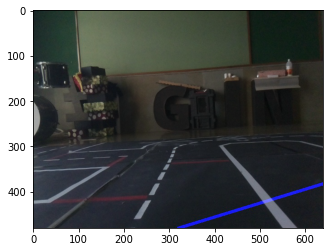

In [10]:

img = cv2.imread("../Brain/sampleimage.jpg")
plt.imshow(img)

88


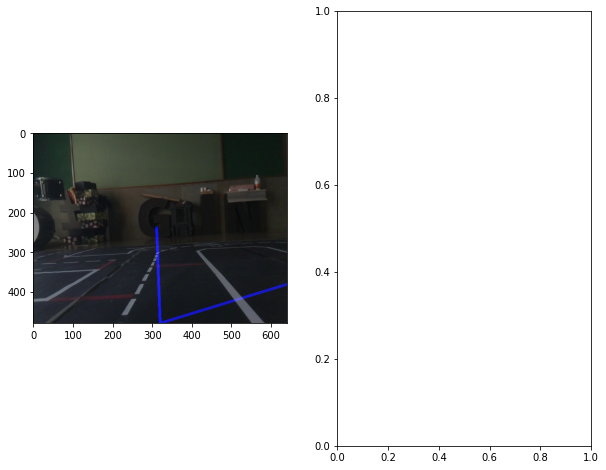

In [11]:
idx = 853
lk = LaneKeep(use_perspective=False, computation_method="hough", debug=False)
angle = lk(img)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.imshow(display_heading_line(img, angle))
print(angle)

In [12]:
lks = [
    #("normal-hough", LaneKeep(use_perspective=False, computation_method="hough")),
    ("perspec-hough", LaneKeep(use_perspective=True, computation_method="hough", debug=False)),
    #("normal-slide_window", LaneKeep(use_perspective=False, computation_method="sliding_window")),
    #("perspec-slide_window", LaneKeep(use_perspective=True, computation_method="sliding_window")),
    
]


In [13]:
#table = []
#for name, lk in lks:
#    a = time.time()
#    lk(col_images)
#    table.append((name, time.time() - a))
#print(tabulate.tabulate(table))


In [14]:
def process_video(video_path: str, out_path: str, lks: List[Callable], table=[]):
    cap = cv2.VideoCapture(video_path)
    out = None
    count = 0
    while cap.isOpened():
        # try:
        ret, frame = cap.read()
        image = frame
        if out == None:
            h, w, _ = image.shape
            out = cv2.VideoWriter(
                out_path, cv2.VideoWriter_fourcc(*"DIVX"), 15, (w, h)
            )

        if not ret or cv2.waitKey(1) == 27:
            break
        angles = [ lk(image) for _,lk in lks]
        
        out_img = display_heading_line(image, angles[0], line_width=10)
        #out_img = display_heading_line(out_img, angles[1], line_width=10, line_color=(255, 255, 0))

        out.write(out_img)
        count += 1
    print(f"No. of frames : {count}")
    cap.release()
    cv2.destroyAllWindows()

# table = []
# for name, lk in lks:
#     a = time.time()
#     process_video("./data/Records/bfmc2020_online_3.avi", f"./out_{name}.avi", lk)
#     table.append((name, time.time() - a))

# print(tabulate.tabulate(table))




In [15]:
process_video("./data/Records/home.mp4", f"./data/home_hough_persp+norm.avi", lks)

/home/alpha91/miniconda3/envs/syft/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/alpha91/miniconda3/envs/syft/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of frames : 2012


In [16]:
print("Byeee !!!")

Byeee !!!
